In [1]:
import os
import pandas as pd
root_dir = '/kaggle/input/vipcup2023/dataset/dataset'
train_label_df = pd.read_csv(os.path.join(root_dir,'Training_Biomarker_Data.csv'))

In [2]:
train_label_df.columns[0]

'Path (Trial/Arm/Folder/Visit/Eye/Image Name)'

In [3]:
row = train_label_df.loc[train_label_df[train_label_df.columns[0]] == '/TREX DME/GILA/0201GOD/V1/OD/TREXJ_000000.tif', :]
print(row)
print('\n\tvalue of B1 is: {}'.format(row.loc[0,'B1']))

    Path (Trial/Arm/Folder/Visit/Eye/Image Name)  B1  B2  B3  B4  B5  B6
0  /TREX DME/GILA/0201GOD/V1/OD/TREXJ_000000.tif   1   0   1   0   0   1

	value of B1 is: 1


In [4]:
print(train_label_df.head(3))
print(train_label_df.shape)
df_path = str(train_label_df.iloc[0,0])
df_path = df_path[1:len(df_path)]
TREX_path = os.path.join(root_dir,'TREX_DME')
test = os.path.join(TREX_path,df_path)
print(test)
test2 = test.replace(TREX_path,"")
print(test2)
print(test)

    Path (Trial/Arm/Folder/Visit/Eye/Image Name)  B1  B2  B3  B4  B5  B6
0  /TREX DME/GILA/0201GOD/V1/OD/TREXJ_000000.tif   1   0   1   0   0   1
1  /TREX DME/GILA/0201GOD/V1/OD/TREXJ_000001.tif   1   0   1   0   0   1
2  /TREX DME/GILA/0201GOD/V1/OD/TREXJ_000002.tif   1   0   1   0   0   1
(9408, 7)
/kaggle/input/vipcup2023/dataset/dataset/TREX_DME/TREX DME/GILA/0201GOD/V1/OD/TREXJ_000000.tif
/TREX DME/GILA/0201GOD/V1/OD/TREXJ_000000.tif
/kaggle/input/vipcup2023/dataset/dataset/TREX_DME/TREX DME/GILA/0201GOD/V1/OD/TREXJ_000000.tif


In [5]:
import os
path = []
for dirname, _, filenames in os.walk(root_dir):
    for filename in filenames:
        path.append(os.path.join(dirname, filename))
print(len(path))

162866


In [6]:
def ImagePathProvider(rood_dir,train_df):
    df_path = train_df.iloc[:,0]
    df_path = [str(i) for i in df_path]
    df_path = [i[1:len(i)] for i in df_path]
    
    TREX = os.path.join(root_dir,'TREX_DME')
    PRIME = os.path.join(root_dir,'Prime_FULL')
    
    trex_path = [os.path.join(TREX,i) for i in df_path if "TREX DME" in i]
    prime_path = [os.path.join(PRIME,i) for i in df_path if "Prime_FULL" in i]
    Img_path = trex_path + prime_path
    
    return Img_path

In [7]:
import torch
if torch.cuda.is_available():
    
    device=torch.device("cuda:0")
    print("Running on the GPU")
    torch.cuda.empty_cache()
  #dataType=torch.float32
else:
    device=torch.device("cpu")
    print("Running on the CPU")
  #dataType=torch.float32

Running on the GPU


In [8]:
torch.tensor([[1,2,3],[1,1,1]]).to(device)

tensor([[1, 2, 3],
        [1, 1, 1]], device='cuda:0')

In [9]:
import random
import os
img_path = ImagePathProvider(root_dir,train_label_df)
total_size = len(img_path)
train_size = int(0.75*total_size)
train_img_path = random.sample(img_path,train_size)
valid_img_path = [i for i in img_path if i not in train_img_path]
print('total images: {}'.format(total_size))
print('validation images: {}'.format(len(valid_img_path)))
print('train images: {}'.format(train_size))

total images: 9408
validation images: 2352
train images: 7056


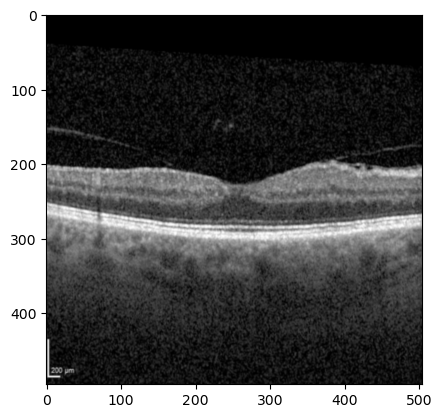

In [10]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
image = Image.open(img_path[3110]).convert("L")
image = np.array(image)
plt.imshow(image, interpolation='bicubic',cmap='gray')
plt.show()

In [11]:
### Creating Dataset
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class VipCup2023_Dataset(Dataset):
   
    def __init__(self,train):
        self.train = train
        self.mean = (.1706)
        self.std = (.2112)
        self.root_dir = '/kaggle/input/vipcup2023/dataset/dataset'
        self.TREX = os.path.join(self.root_dir,'TREX_DME')
        self.Prime = os.path.join(self.root_dir,'Prime_FULL')
        self.df = pd.read_csv(os.path.join(self.root_dir,'Training_Biomarker_Data.csv'))
        self.df_path = None
        self.img_paths = None
        self.transforms = None
        if self.train==True:
            self.img_paths = train_img_path
            self.transforms = transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.2, 1.)),
        transforms.RandomHorizontalFlip(),

        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
       transforms.Normalize(mean=self.mean, std=self.std)
    ])
        else :
            self.img_paths = valid_img_path
            self.transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=self.mean, std=self.std)
    ])
        
    
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        if self.TREX in self.img_paths[idx]:
            self.df_path = self.img_paths[idx].replace(self.TREX,"")
            
        elif self.Prime in self.img_paths[idx]:
            self.df_path = self.img_paths[idx].replace(self.Prime,"")
        
        path = self.img_paths[idx] 
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        row = self.df.loc[self.df[self.df.columns[0]] == self.df_path, :]
        b1 = row.iloc[0,1]
        b2 = row.iloc[0,2]
        b3 = row.iloc[0,3]
        b4 = row.iloc[0,4]
        b5 = row.iloc[0,5]
        b6 = row.iloc[0,6]
        bio_tensor = torch.tensor([b1, b2, b3, b4, b5, b6])
        return image, bio_tensor

In [12]:
## Creating Model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision

class ResNet(nn.Module):
    """encoder + classifier"""
    def __init__(self, name='resnet50', num_classes=2):
        super(ResNet, self).__init__()
        if (name == 'resnet50'):
            self.encoder = torchvision.models.resnet50(zero_init_residual=True)
            self.encoder.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            self.encoder.fc = nn.Identity()
            self.fc = nn.Linear(2048, num_classes)
        else:
            self.encoder = torchvision.models.resnet18(zero_init_residual=True)
            self.encoder.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            self.encoder.fc = nn.Identity()
            self.fc = nn.Linear(512, num_classes)
    def forward(self, x):

        return self.fc(self.encoder(x))


In [13]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [14]:
# Training step
import sys
import time
def train_supervised(train_loader, model,criterion, optimizer, epoch,device='cpu'):
    """one epoch training"""
    model.train()
    print_freq = 10

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    device = device
    end = time.time()

    for idx, (image, bio_tensor) in enumerate(train_loader):
        data_time.update(time.time() - end)

        images = image.to(device)

        labels = bio_tensor.float()

        labels = labels.to(device)
        bsz = labels.shape[0]

        # compute loss


        output = model(images)
        loss = criterion(output, labels)

        # update metric
        losses.update(loss.item(), bsz)

        # SGD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # print info
        if (idx + 1) % print_freq == 0:
            print('Train: [{0}][{1}/{2}]\t'.format(
                epoch, idx + 1, len(train_loader)))

            sys.stdout.flush()

    return losses.avg


In [15]:
batch_size = 16
train_dataset = VipCup2023_Dataset(train=True)
valid_dataset = VipCup2023_Dataset(train=False)            
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=2, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False,num_workers=2, pin_memory=True)

In [16]:
print(len(train_loader))
x = iter(train_loader)
y = next(x)
image,bioTensor = y
image.shape

441


torch.Size([16, 1, 224, 224])

In [17]:
from torch import optim
epoch_train_loss=[]
epochs = 100
model = ResNet(num_classes=6)
model = model.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
criterion = criterion.to(device)
optimizer = optim.SGD(model.parameters(),lr=0.05,momentum=0.9,weight_decay=1e-4)

for epoch in range(1,epochs+1):
    train_loss = train_supervised(train_loader,model,criterion,optimizer,epoch,device=device)
    epoch_train_loss.append(train_loss)

Train: [1][10/441]	
Train: [1][20/441]	
Train: [1][30/441]	
Train: [1][40/441]	
Train: [1][50/441]	
Train: [1][60/441]	
Train: [1][70/441]	
Train: [1][80/441]	
Train: [1][90/441]	
Train: [1][100/441]	
Train: [1][110/441]	
Train: [1][120/441]	
Train: [1][130/441]	
Train: [1][140/441]	
Train: [1][150/441]	
Train: [1][160/441]	
Train: [1][170/441]	
Train: [1][180/441]	
Train: [1][190/441]	
Train: [1][200/441]	
Train: [1][210/441]	
Train: [1][220/441]	
Train: [1][230/441]	
Train: [1][240/441]	
Train: [1][250/441]	
Train: [1][260/441]	
Train: [1][270/441]	
Train: [1][280/441]	
Train: [1][290/441]	
Train: [1][300/441]	
Train: [1][310/441]	
Train: [1][320/441]	
Train: [1][330/441]	
Train: [1][340/441]	
Train: [1][350/441]	
Train: [1][360/441]	
Train: [1][370/441]	
Train: [1][380/441]	
Train: [1][390/441]	
Train: [1][400/441]	
Train: [1][410/441]	
Train: [1][420/441]	
Train: [1][430/441]	
Train: [1][440/441]	
Train: [2][10/441]	
Train: [2][20/441]	
Train: [2][30/441]	
Train: [2][40/441]	
Train

In [18]:
import numpy as np
from sklearn.metrics import f1_score
def sample_evaluation(val_loader, model, device):
    """validation"""
    model.eval()
    out_list = []
    label_list = []
    with torch.no_grad():
        for idx, (image,bio_tensor) in (enumerate(val_loader)):

            images = image.float().to(device)
            labels = bio_tensor.float()

            labels = labels.float()

            label_list.append(labels.squeeze().detach().cpu().numpy())
            # forward
            output = model(images)
            output = torch.round(torch.sigmoid(output))
            out_list.append(output.squeeze().detach().cpu().numpy())

    label_array = np.array(label_list)
    out_array = np.array(out_list)
    f = f1_score(y_true=label_array,y_pred=out_array,average='macro')
    print(f)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [19]:
# !pip install --force-reinstall numpy==1.22.4

In [20]:
# sample_evaluation(valid_loader,model,device)